In [73]:
%matplotlib notebook
import matplotlib.pyplot as plt 
import numpy as np
import torch

import nmf.mult
import nmf.pgrad
import nmf.nesterov

import nmf_torch.mult
import nmf_torch.pgrad
import nmf_torch.nesterov
import nmf_torch.norms

from theory.represent import rescale_WH

from read_data.reading import read_face_images, images_matrix_grid,\
                                roll_images, unroll_images 

from performance.performance_eval_func import get_random_lowrank_matrix, get_time_ratio,\
                                              compare_performance, plot_performance,\
                                              torch_algo_wrapper

In [28]:
def errors_at_time_t_over_inner_dim(V, r_range, t, algo_dict): 
    error_data  = {algo_name: [] for algo_name in algo_dict.keys()}

    for r in r_range:
        W_init, H_init = nmf.mult.update_empty_initials(V, r, None, None)
        for algo_name, algo in algo_dict.items():
            W, H = algo(V=V, inner_dim=r, 
                        record_errors=False,
                        time_limit=t,
                        max_steps=np.inf,
                        epsilon=0,
                        W_init=W_init.copy(),
                        H_init=H_init.copy()) 
            error = nmf.norms.norm_Frobenius(V - W@H)
            error_data[algo_name].append([r, error])
    return {k:np.array(v) for k,v in error_data.items()}


def plot_dict(dict_data, ax, log=False):
    for k,v in dict_data.items():
        ls = "--" if "torch" in k else "-"
        y_data = np.log(v[:, 1]) if log else v[:, 1] 
        ax.plot(v[:, 0], y_data, label=k, ls=ls)
    ax.legend()
    return ax

In [13]:
image_data = read_face_images("data/att_faces/images").astype(float)

<IPython.core.display.Javascript object>


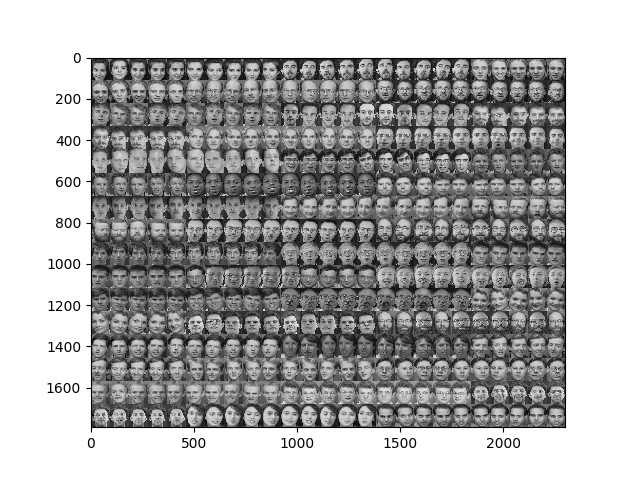

In [83]:
grid = images_matrix_grid(image_data, (16, 25))
plt.imshow(grid, cmap="gray")

In [15]:
unrolled_image_data, ori_shape = unroll_images(image_data)

In [38]:
unrolled_image_data.shape

(400, 10304)

In [17]:
algo_dict_to_test = {
    "mult": nmf.mult.factorise_Fnorm,
    "pgrad": nmf.pgrad.factorise_Fnorm_subproblems,
    "nesterov": nmf.nesterov.factorise_Fnorm,

    "mult_torch": torch_algo_wrapper(nmf_torch.mult.factorise_Fnorm, 
                                     device="cuda"),
    "pgrad_torch": torch_algo_wrapper(nmf_torch.pgrad.factorise_Fnorm_subproblems, 
                                      device="cuda"),
    "nesterov_torch": torch_algo_wrapper(nmf_torch.nesterov.factorise_Fnorm, 
                                        device="cuda")
}

In [40]:
errors_result = errors_at_time_t_over_inner_dim(unrolled_image_data, range(5, 360, 20),
                             30, {"nesterov_torch":algo_dict_to_test["nesterov_torch"]})

<IPython.core.display.Javascript object>


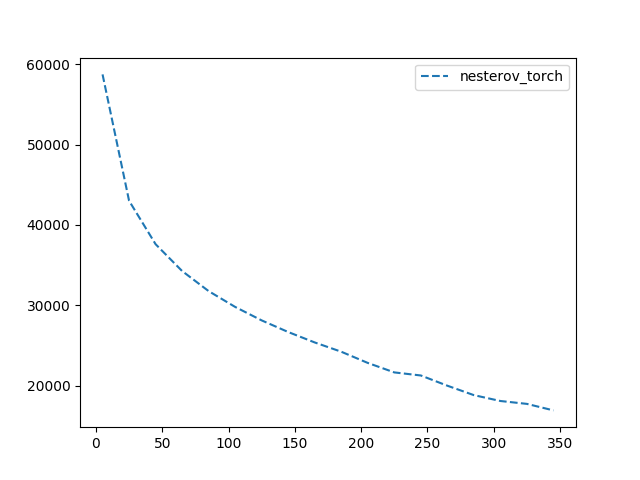

In [64]:
f, ax = plt.subplots()
plot_dict(errors_result, ax, log=False)

In [36]:
shape = unrolled_image_data.shape
inner_dims = [2, 25, 50, 100, 150, 200]
W_init = np.random.rand(shape[0], inner_dim)
H_init = np.random.rand(inner_dim, shape[1])

performances = {}
for inner_dim in inner_dims:
    performance = compare_performance(unrolled_image_data, 
                                      inner_dim, time_limit=100,
                                      W_init=W_init, H_init=H_init, 
                                      algo_dict_to_test=algo_dict_to_test)
    performances[inner_dim] = performance

<IPython.core.display.Javascript object>


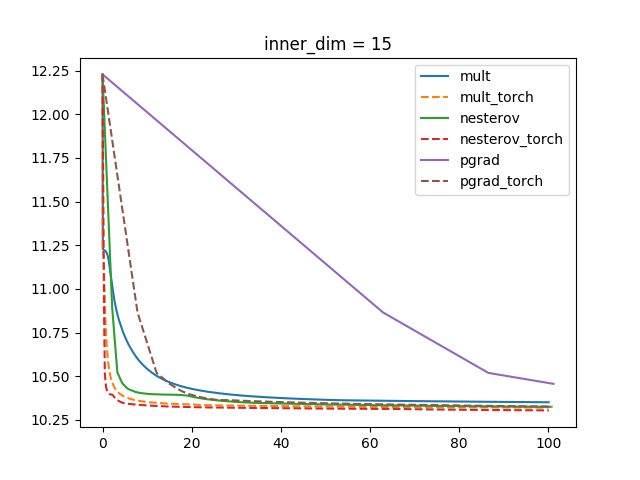

<IPython.core.display.Javascript object>


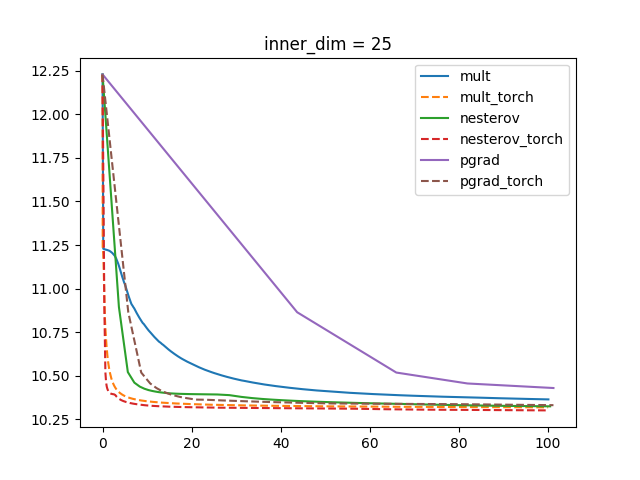

<IPython.core.display.Javascript object>


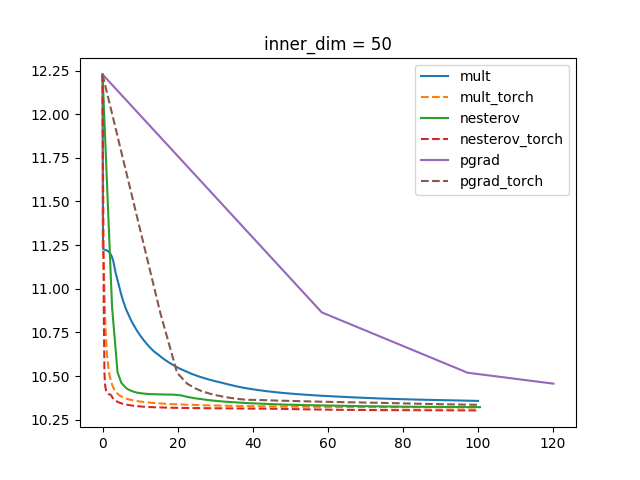

<IPython.core.display.Javascript object>


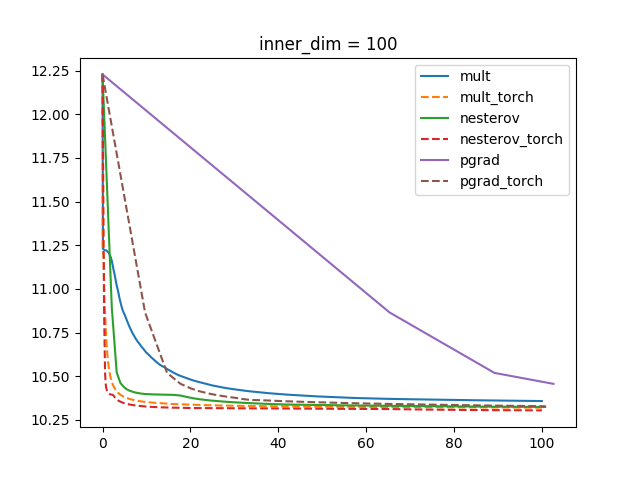

<IPython.core.display.Javascript object>


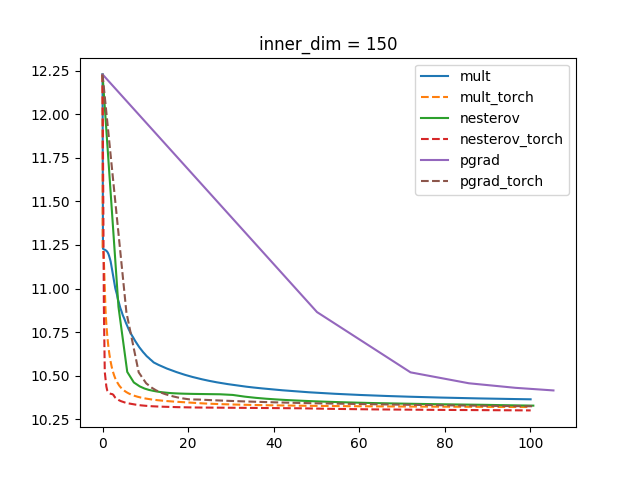

<IPython.core.display.Javascript object>


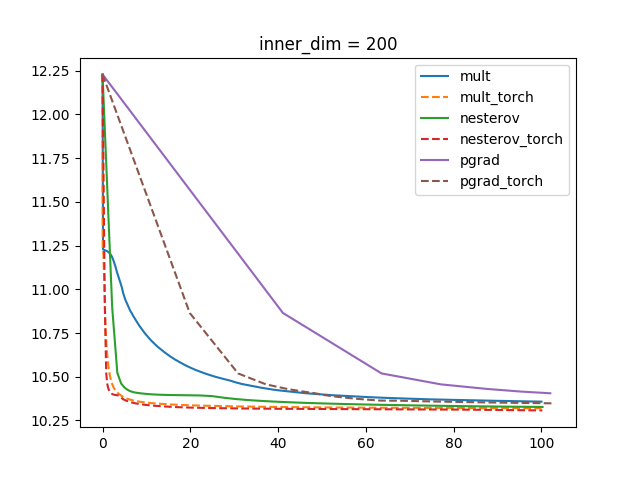

In [37]:
for inner_dim in inner_dims:
    f, ax = plt.subplots()
    ax.set_title("inner_dim = {}".format(inner_dim))
    performance = performances[inner_dim]
    plot_performance(performance, ax)

In [60]:
def plot_ratios_gpu_algo(errors, ax, base="mult_torch"):
    ratios = get_time_ratio(errors[base], errors["nesterov_torch"])
    ax.plot(ratios[:, 0], ratios[:, 1], label="nesterov_torch")

    ratios = get_time_ratio(errors[base], errors["mult_torch"])
    ax.plot(ratios[:, 0], ratios[:, 1], label="mult_torch")

    ratios = get_time_ratio(errors[base], errors["pgrad_torch"])
    ax.plot(ratios[:, 0], ratios[:, 1], label="pgrad_torch")
    
    ax.set_title("How faster is X than {} on GPU".format(base))
    ax.invert_xaxis()
    ax.legend()

In [61]:
def plot_ratios_cpu_algo(errors, ax, base="mult"):
    ratios = get_time_ratio(errors[base], errors["nesterov"])
    ax.plot(ratios[:, 0], ratios[:, 1], label="nesterov")

    ratios = get_time_ratio(errors[base], errors["mult"])
    ax.plot(ratios[:, 0], ratios[:, 1], label="mult")

    ratios = get_time_ratio(errors[base], errors["pgrad"])
    ax.plot(ratios[:, 0], ratios[:, 1], label="pgrad")

    ax.set_title("How faster is X than {} on CPU".format(base))
    ax.invert_xaxis()
    ax.legend()

In [62]:
def plot_ratios_cpu_gpu(errors, ax):
    ratios = get_time_ratio(errors["nesterov"], errors["nesterov_torch"])
    ax.plot(ratios[:, 0], ratios[:, 1], label="nesterov")

    ratios = get_time_ratio(errors["mult"], errors["mult_torch"])
    ax.plot(ratios[:, 0], ratios[:, 1], label="mult")

    ratios = get_time_ratio(errors["pgrad"], errors["pgrad_torch"])
    ax.plot(ratios[:, 0], ratios[:, 1], label="pgrad")

    ax.set_title("How faster is X on GPU than on CPU")
    ax.invert_xaxis()
    ax.legend()

<IPython.core.display.Javascript object>


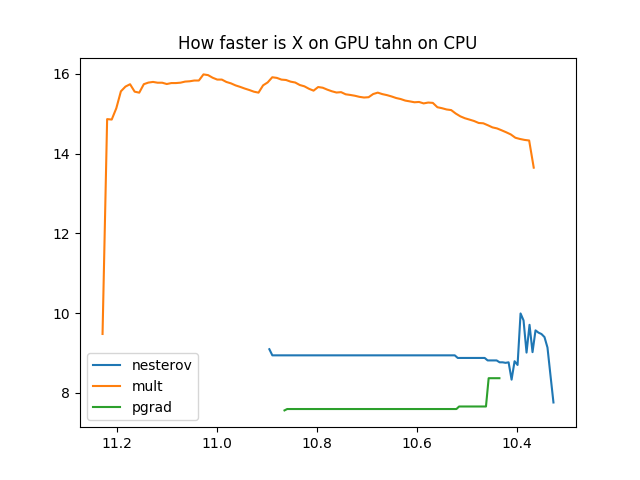

<IPython.core.display.Javascript object>


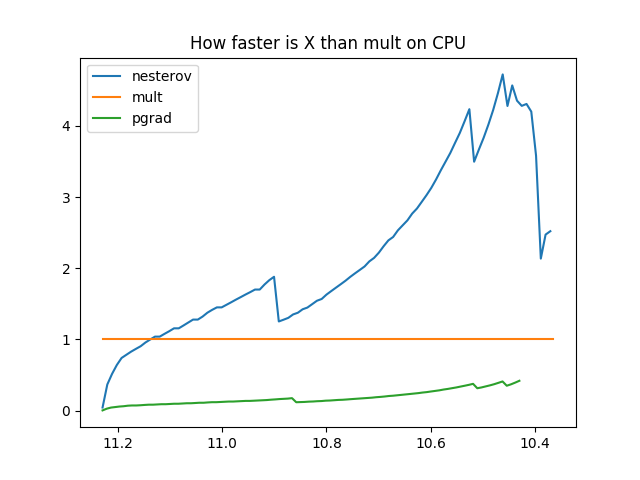

<IPython.core.display.Javascript object>


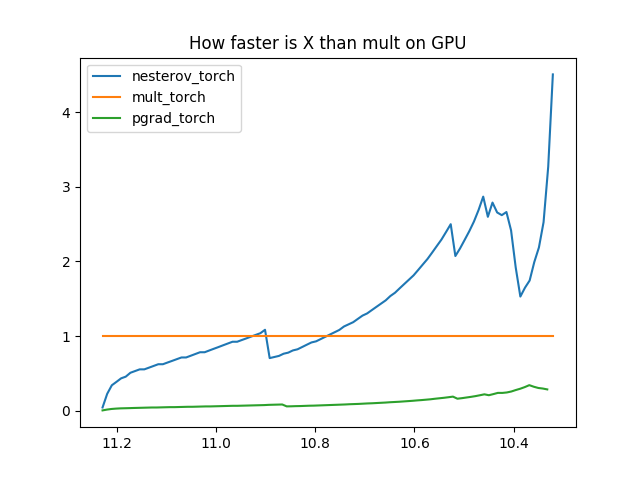

In [65]:
f, ax = plt.subplots()
plot_ratios_cpu_gpu(performances[25], ax)
f, ax = plt.subplots()
plot_ratios_cpu_algo(performances[25], ax)
f, ax = plt.subplots()
plot_ratios_gpu_algo(performances[25], ax)

In [71]:
nesterov = torch_algo_wrapper(nmf_torch.nesterov.factorise_Fnorm, device="cuda")
W, H = nesterov(V=unrolled_image_data, inner_dim=25, time_limit=40, max_steps=np.inf)

In [74]:
W, H = rescale_WH(W, H)

<IPython.core.display.Javascript object>


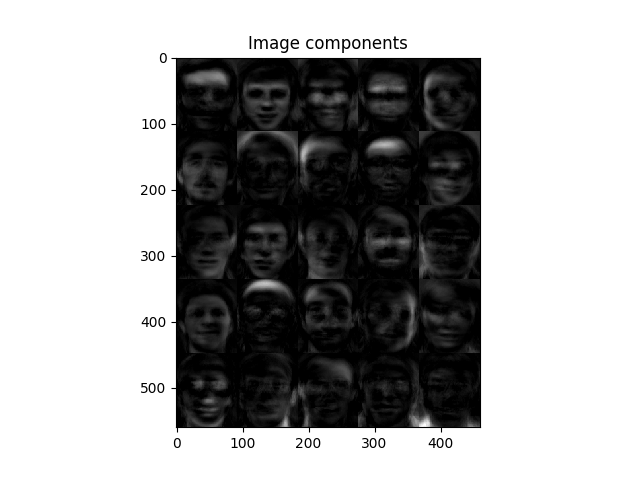

Text(0.5, 1.0, 'Image components')

In [77]:
image_components = roll_images(H, ori_shape)
grid = images_matrix_grid(image_components, (5, 5))
f, ax = plt.subplots()
ax.imshow(grid, cmap="gray")
ax.set_title("Image components")

<IPython.core.display.Javascript object>


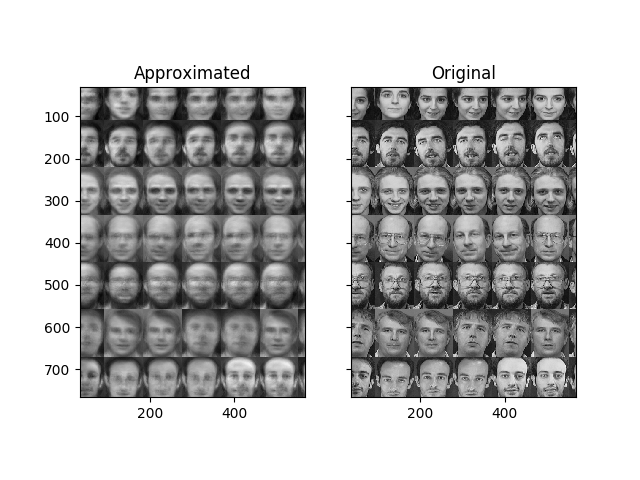

Text(0.5, 1.0, 'Original')

In [82]:
f, [ax1, ax2] = plt.subplots(ncols=2, sharex=True, sharey=True)

approx_unrolled_image_data = W @ H
approx_image_data = roll_images(approx_unrolled_image_data, ori_shape)
grid = images_matrix_grid(approx_image_data, (40, 10))
ax1.imshow(grid, cmap="gray"); ax1.set_title("Approximated")
grid = images_matrix_grid(image_data, (40, 10))
ax2.imshow(grid, cmap="gray"); ax2.set_title("Original")